In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import train
import preprocessing
import test

import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams.update({'font.size': 12})

## Load and prepare the data

In [2]:
#Run to get new call data
client = Socrata("data.seattle.gov", None)

# Returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("kzjm-xkqj", limit = 1000000)


# Convert query results to pandas DataFrame
df = pd.DataFrame.from_records(results)
df = df.iloc[:,:7]
df = preprocessing.add_time_features(df)


# Run to get new weather data
from wwo_hist import retrieve_hist_data
frequency = 1
start_date = df.date.iloc[-1].strftime("%d-%b-%Y")
end_date = df.date.iloc[0].strftime("%d-%b-%Y")
api_key = '2d65942715e14539bbc163119222808'
location_list = ['seattle']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for seattle


Currently retrieving data for seattle: from 2012-08-19 to 2012-08-31
Time elapsed (hh:mm:ss.ms) 0:00:00.435423
Currently retrieving data for seattle: from 2012-09-01 to 2012-09-30
Time elapsed (hh:mm:ss.ms) 0:00:01.061255
Currently retrieving data for seattle: from 2012-10-01 to 2012-10-31
Time elapsed (hh:mm:ss.ms) 0:00:01.719725
Currently retrieving data for seattle: from 2012-11-01 to 2012-11-30
Time elapsed (hh:mm:ss.ms) 0:00:02.346852
Currently retrieving data for seattle: from 2012-12-01 to 2012-12-31
Time elapsed (hh:mm:ss.ms) 0:00:02.982790
Currently retrieving data for seattle: from 2013-01-01 to 2013-01-31
Time elapsed (hh:mm:ss.ms) 0:00:03.621494
Currently retrieving data for seattle: from 2013-02-01 to 2013-02-28
Time elapsed (hh:mm:ss.ms) 0:00:04.266794
Currently retrieving data for seattle: from 2013-03-01 to 2013-03-31
Time elapsed (hh:mm:ss.ms) 0:00:04.953880
Currently retrieving data for seattle: from 2013-04-01 to 2013-04-30
Tim

Time elapsed (hh:mm:ss.ms) 0:00:50.645921
Currently retrieving data for seattle: from 2018-10-01 to 2018-10-31
Time elapsed (hh:mm:ss.ms) 0:00:51.339543
Currently retrieving data for seattle: from 2018-11-01 to 2018-11-30
Time elapsed (hh:mm:ss.ms) 0:00:52.258121
Currently retrieving data for seattle: from 2018-12-01 to 2018-12-31
Time elapsed (hh:mm:ss.ms) 0:00:52.904383
Currently retrieving data for seattle: from 2019-01-01 to 2019-01-31
Time elapsed (hh:mm:ss.ms) 0:00:53.551019
Currently retrieving data for seattle: from 2019-02-01 to 2019-02-28
Time elapsed (hh:mm:ss.ms) 0:00:54.129113
Currently retrieving data for seattle: from 2019-03-01 to 2019-03-31
Time elapsed (hh:mm:ss.ms) 0:00:54.794332
Currently retrieving data for seattle: from 2019-04-01 to 2019-04-30
Time elapsed (hh:mm:ss.ms) 0:00:55.485529
Currently retrieving data for seattle: from 2019-05-01 to 2019-05-31
Time elapsed (hh:mm:ss.ms) 0:00:56.145577
Currently retrieving data for seattle: from 2019-06-01 to 2019-06-30
T

In [3]:
grouped_df = preprocessing.group_df_func(df, ['year', 'month', 'day'], date_col = False)
for i in range(5):
    grouped_df['num_calls_prev'+str(i+1)] = grouped_df.num_calls.shift(i+1)

In [4]:
weather = hist_weather_data[0].copy()
weather = weather.rename({'date_time': 'datetime'}, axis=1)
weather = weather[['datetime','tempC','visibility','windspeedKmph','totalSnow_cm']]
weather[['tempC','visibility','windspeedKmph','totalSnow_cm']] = weather[['tempC','visibility','windspeedKmph','totalSnow_cm']].astype('float')
weather = preprocessing.add_time_features(weather)
weather.head(5)

,datetime,tempC,visibility,windspeedKmph,totalSnow_cm,year,month,dayofweek,hour,day,date
0,2012-08-19 00:00:00,15.0,2.0,8.0,0.0,2012,8,6,0,19,2012-08-19
1,2012-08-19 01:00:00,15.0,2.0,7.0,0.0,2012,8,6,1,19,2012-08-19
2,2012-08-19 02:00:00,14.0,2.0,6.0,0.0,2012,8,6,2,19,2012-08-19
3,2012-08-19 03:00:00,14.0,2.0,6.0,0.0,2012,8,6,3,19,2012-08-19
4,2012-08-19 04:00:00,15.0,5.0,6.0,0.0,2012,8,6,4,19,2012-08-19


In [5]:
weather = weather.groupby(['year','month','day']).mean().reset_index()
grouped_df = pd.concat([grouped_df,weather[['tempC','windspeedKmph']]], axis = 1)
grouped_df = grouped_df.iloc[-7*12*30:]
grouped_df.head()

,year,month,day,num_calls,num_calls_prev1,num_calls_prev2,num_calls_prev3,num_calls_prev4,num_calls_prev5,tempC,windspeedKmph
1144,2015,10,7,323,273.0,262.0,287.0,266.0,262.0,13.791667,6.291667
1145,2015,10,8,308,323.0,273.0,262.0,287.0,266.0,15.916667,3.458333
1146,2015,10,9,321,308.0,323.0,273.0,262.0,287.0,14.791667,8.208333
1147,2015,10,10,277,321.0,308.0,323.0,273.0,262.0,14.708333,13.541667
1148,2015,10,11,294,277.0,321.0,308.0,323.0,273.0,12.958333,4.958333


### Dummy variables


In [6]:
dummy_fields = ['year', 'month', 'day']
for each in dummy_fields:
    dummies = pd.get_dummies(grouped_df[each], prefix=each, drop_first=False)
    grouped_df = pd.concat([grouped_df, dummies], axis=1)

fields_to_drop = ['year','month','day']
data = grouped_df.drop(fields_to_drop, axis=1)
data = data.reset_index(drop=True)
data.head()

,num_calls,num_calls_prev1,num_calls_prev2,num_calls_prev3,num_calls_prev4,num_calls_prev5,tempC,windspeedKmph,year_2015,year_2016,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,323,273.0,262.0,287.0,266.0,262.0,13.791667,6.291667,1,0,...,0,0,0,0,0,0,0,0,0,0
1,308,323.0,273.0,262.0,287.0,266.0,15.916667,3.458333,1,0,...,0,0,0,0,0,0,0,0,0,0
2,321,308.0,323.0,273.0,262.0,287.0,14.791667,8.208333,1,0,...,0,0,0,0,0,0,0,0,0,0
3,277,321.0,308.0,323.0,273.0,262.0,14.708333,13.541667,1,0,...,0,0,0,0,0,0,0,0,0,0
4,294,277.0,321.0,308.0,323.0,273.0,12.958333,4.958333,1,0,...,0,0,0,0,0,0,0,0,0,0


### Scaling target variables
To make training the network easier, I standardized each of the continuous variables. 

In [7]:
# Save data for approximately the last 6 months  
test_data = data[-6*30:]

# Now removing the test data from the data set 
data = data[:-6*30]

# quant_features = ['tempC','windspeedKmph','num_calls']
quant_features = ['num_calls','num_calls_prev1','num_calls_prev2','num_calls_prev3',
                  'num_calls_prev4','num_calls_prev5','tempC','windspeedKmph',]
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    test_data.loc[:, each] = (test_data[each] - mean)/std

### Splitting the data into training, testing, and validation sets


In [8]:
# Separate the data into features and targets
target_fields = ['num_calls']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Splitting the data into two sets, one for training and one for validating as the network is being trained. 

In [9]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-30*6], targets[:-30*6]
val_features, val_targets = features[-30*6:], targets[-30*6:]

In [10]:
from my_answers import NeuralNetwork

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [12]:
import sys

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['num_calls']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(np.array(network.run(train_features)).T, train_targets['num_calls'].values)
    val_loss = MSE(np.array(network.run(val_features)).T, val_targets['num_calls'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.518 ... Validation loss: 0.713

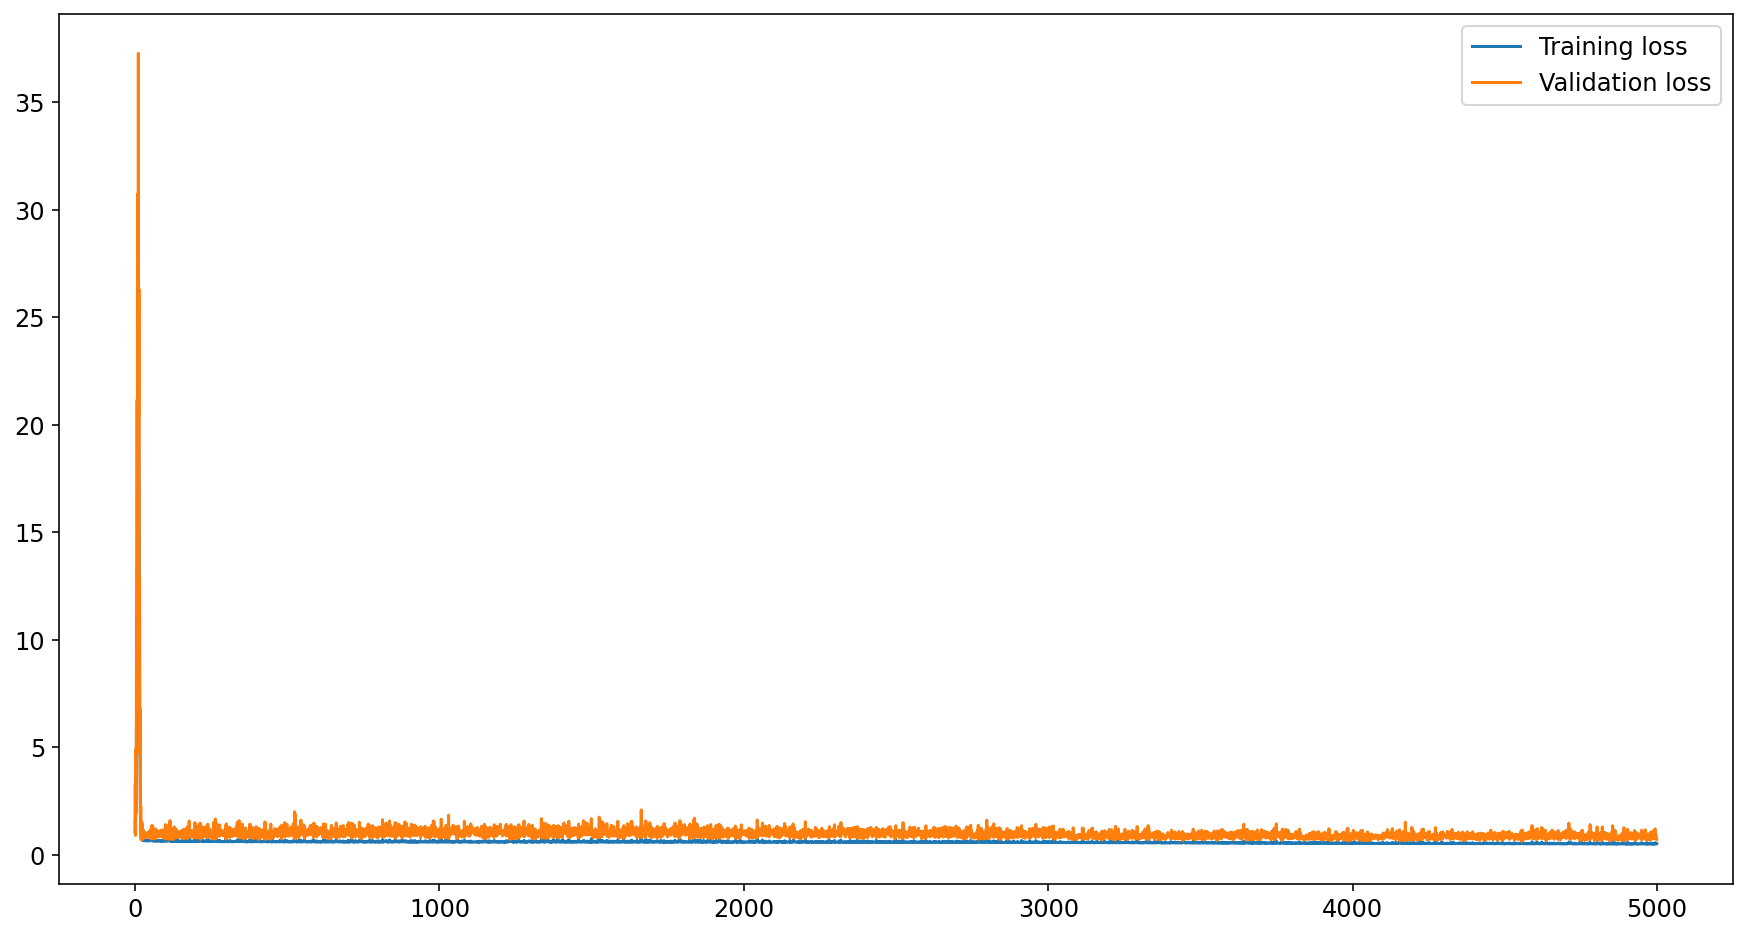

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Checking predictions


The mean squared error is: 1277.6160447175369
The mean absolute error is: 23.23436983355381


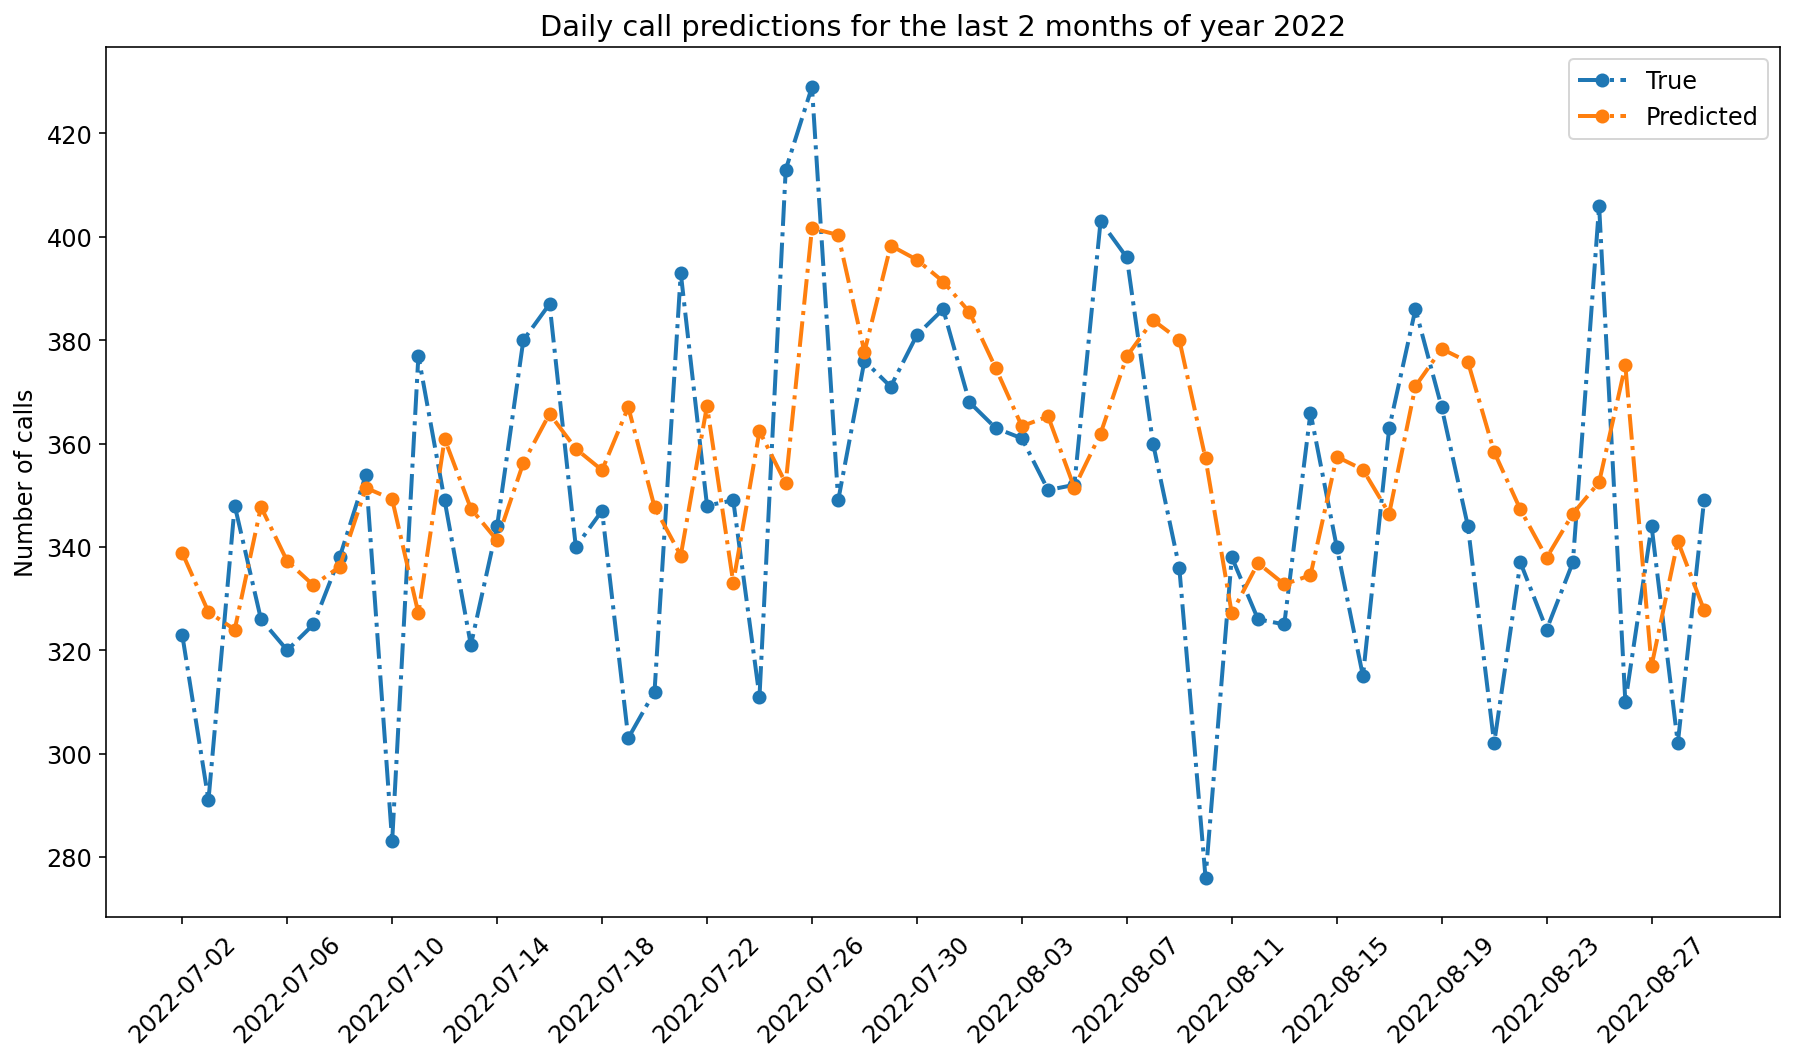

The mean squared error is: 1277.6160447175369
The mean absolute error is: 23.23436983355381


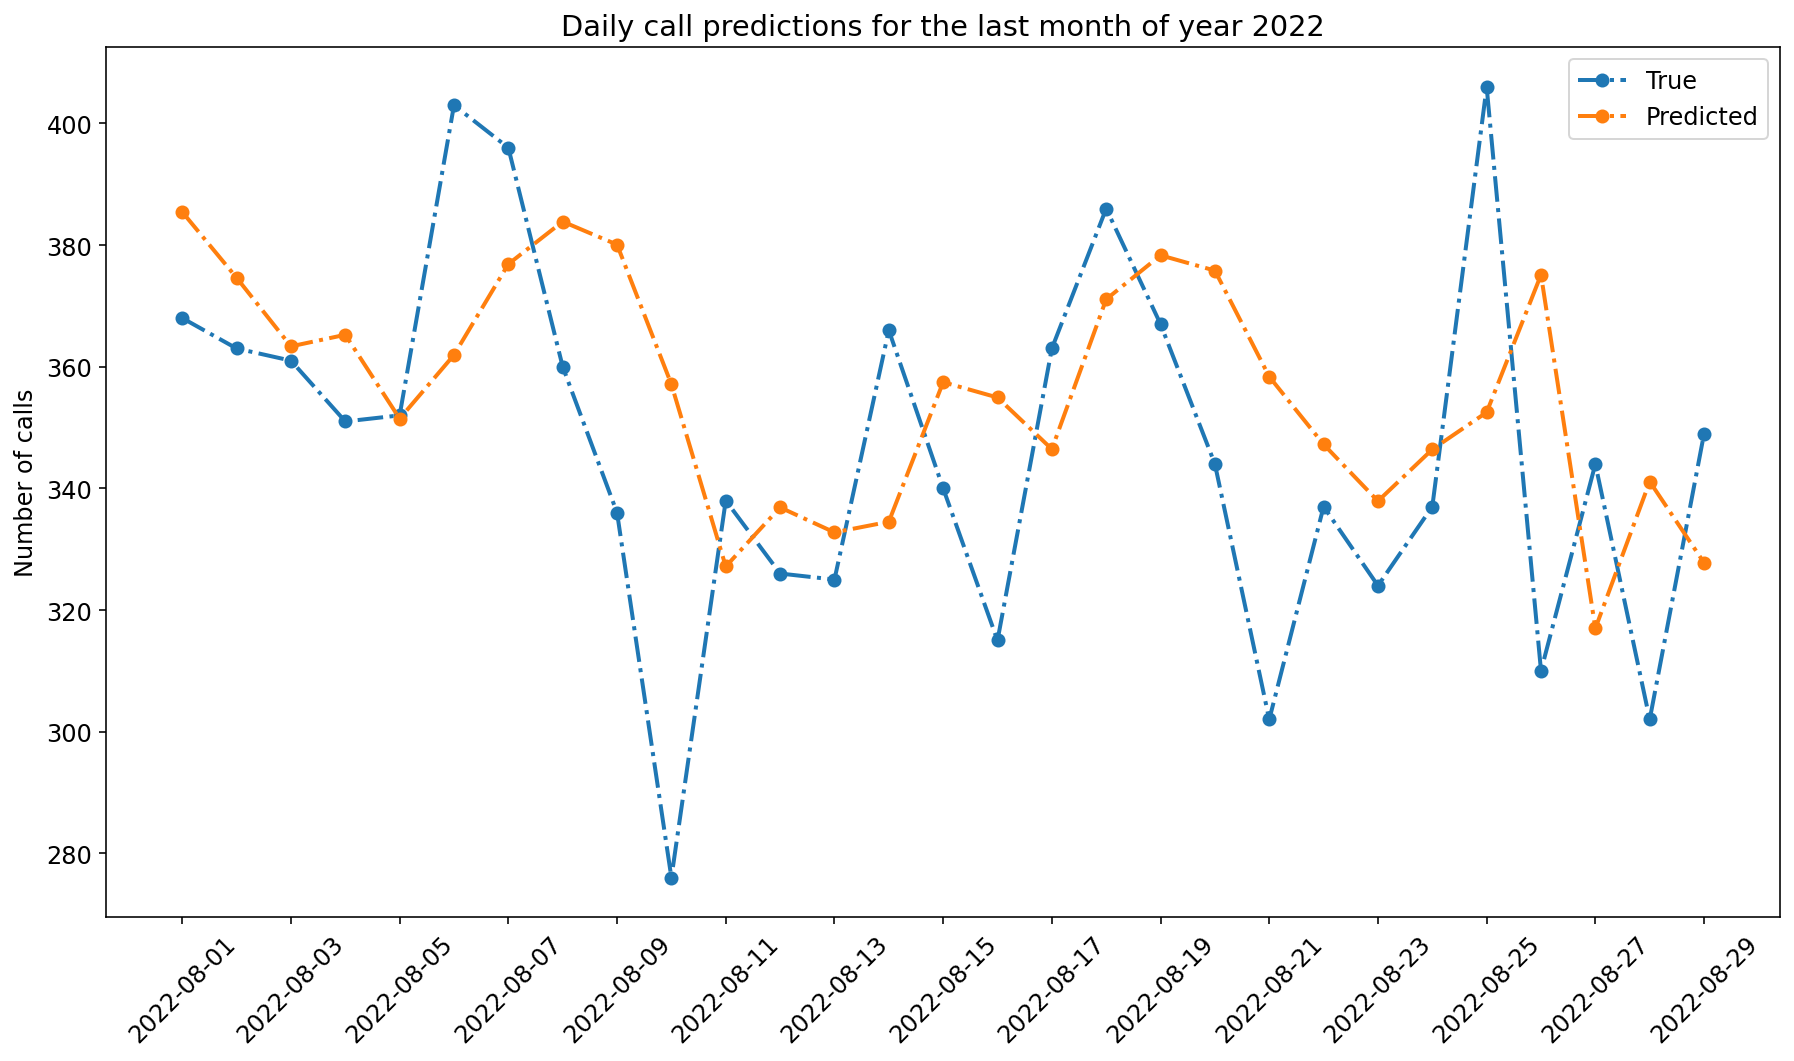

In [14]:
mean, std = scaled_features['num_calls']
predictions = np.array(network.run(test_features)).T*std + mean
results_df = test.convert_results_dataframe(test_targets['num_calls']*std + mean, 
                                            predictions[0], grouped_df.reset_index(drop=True).iloc[-30*2:], 'daily')
results_df = test.evaluate_predictions(results_df, 60, 'daily','Daily call predictions for the last 2 months of year 2022')

results_df = test.evaluate_predictions(results_df, 30,'daily', 'Daily call predictions for the last month of year 2022')